In [138]:
from lime import lime_image
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [139]:
model = tf.keras.models.load_model('../saved_model.h5')

In [140]:
target = [
    'beagle', 'cocker_spaniel', 'golden_retriever',
    'maltese', 'pekinese', 'pomeranian', 'poodle',
    'samoyed', 'shih_tzu', 'white_terrier']


In [141]:
def img_preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img = np.array(img)
    img = img / 255
    return img

In [169]:
def explain_image(img_path):
    img = img_preprocess(img_path)
    explainer = lime_image.LimeImageExplainer()

    # 이미지를 슈퍼픽셀로 분할하는 알고리즘 설정
    # quickshift, slic, felzenswalb 등이 존재
    segmenter = SegmentationAlgorithm('slic',
                                    n_segments=100,  # 이미지 분할 조각 개수
                                    compactnes=1,  # 유사한 파트를 합치는 함수
                                    sigma=1)  # 스무딩 역할: 0과 1사이의 float

    explanation = explainer.explain_instance(img,
                                            classifier_fn=model.predict,  # 10개 class 확률 반환
                                            top_labels=4,  # 확률 기준 1~5위
                                            num_samples=1000,  # sample space
                                            segmentation_fn=segmenter)  # 분할 알고리즘                                            
    for i in range(4):
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=False)
        plt.rcParams["figure.figsize"] = (32, 32)
        plt.subplot(2, 2, i + 1)
        plt.title(f'Explain {i + 1}')
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    plt.show()

    np_img = np.array([img])
    pred = model.predict(np_img)
    pred_idx = np.argmax(pred)
    print(f'This image is {pred[0][pred_idx] * 100 :.2f}% {target[pred_idx]}')


100%|██████████| 1000/1000 [00:08<00:00, 120.60it/s]


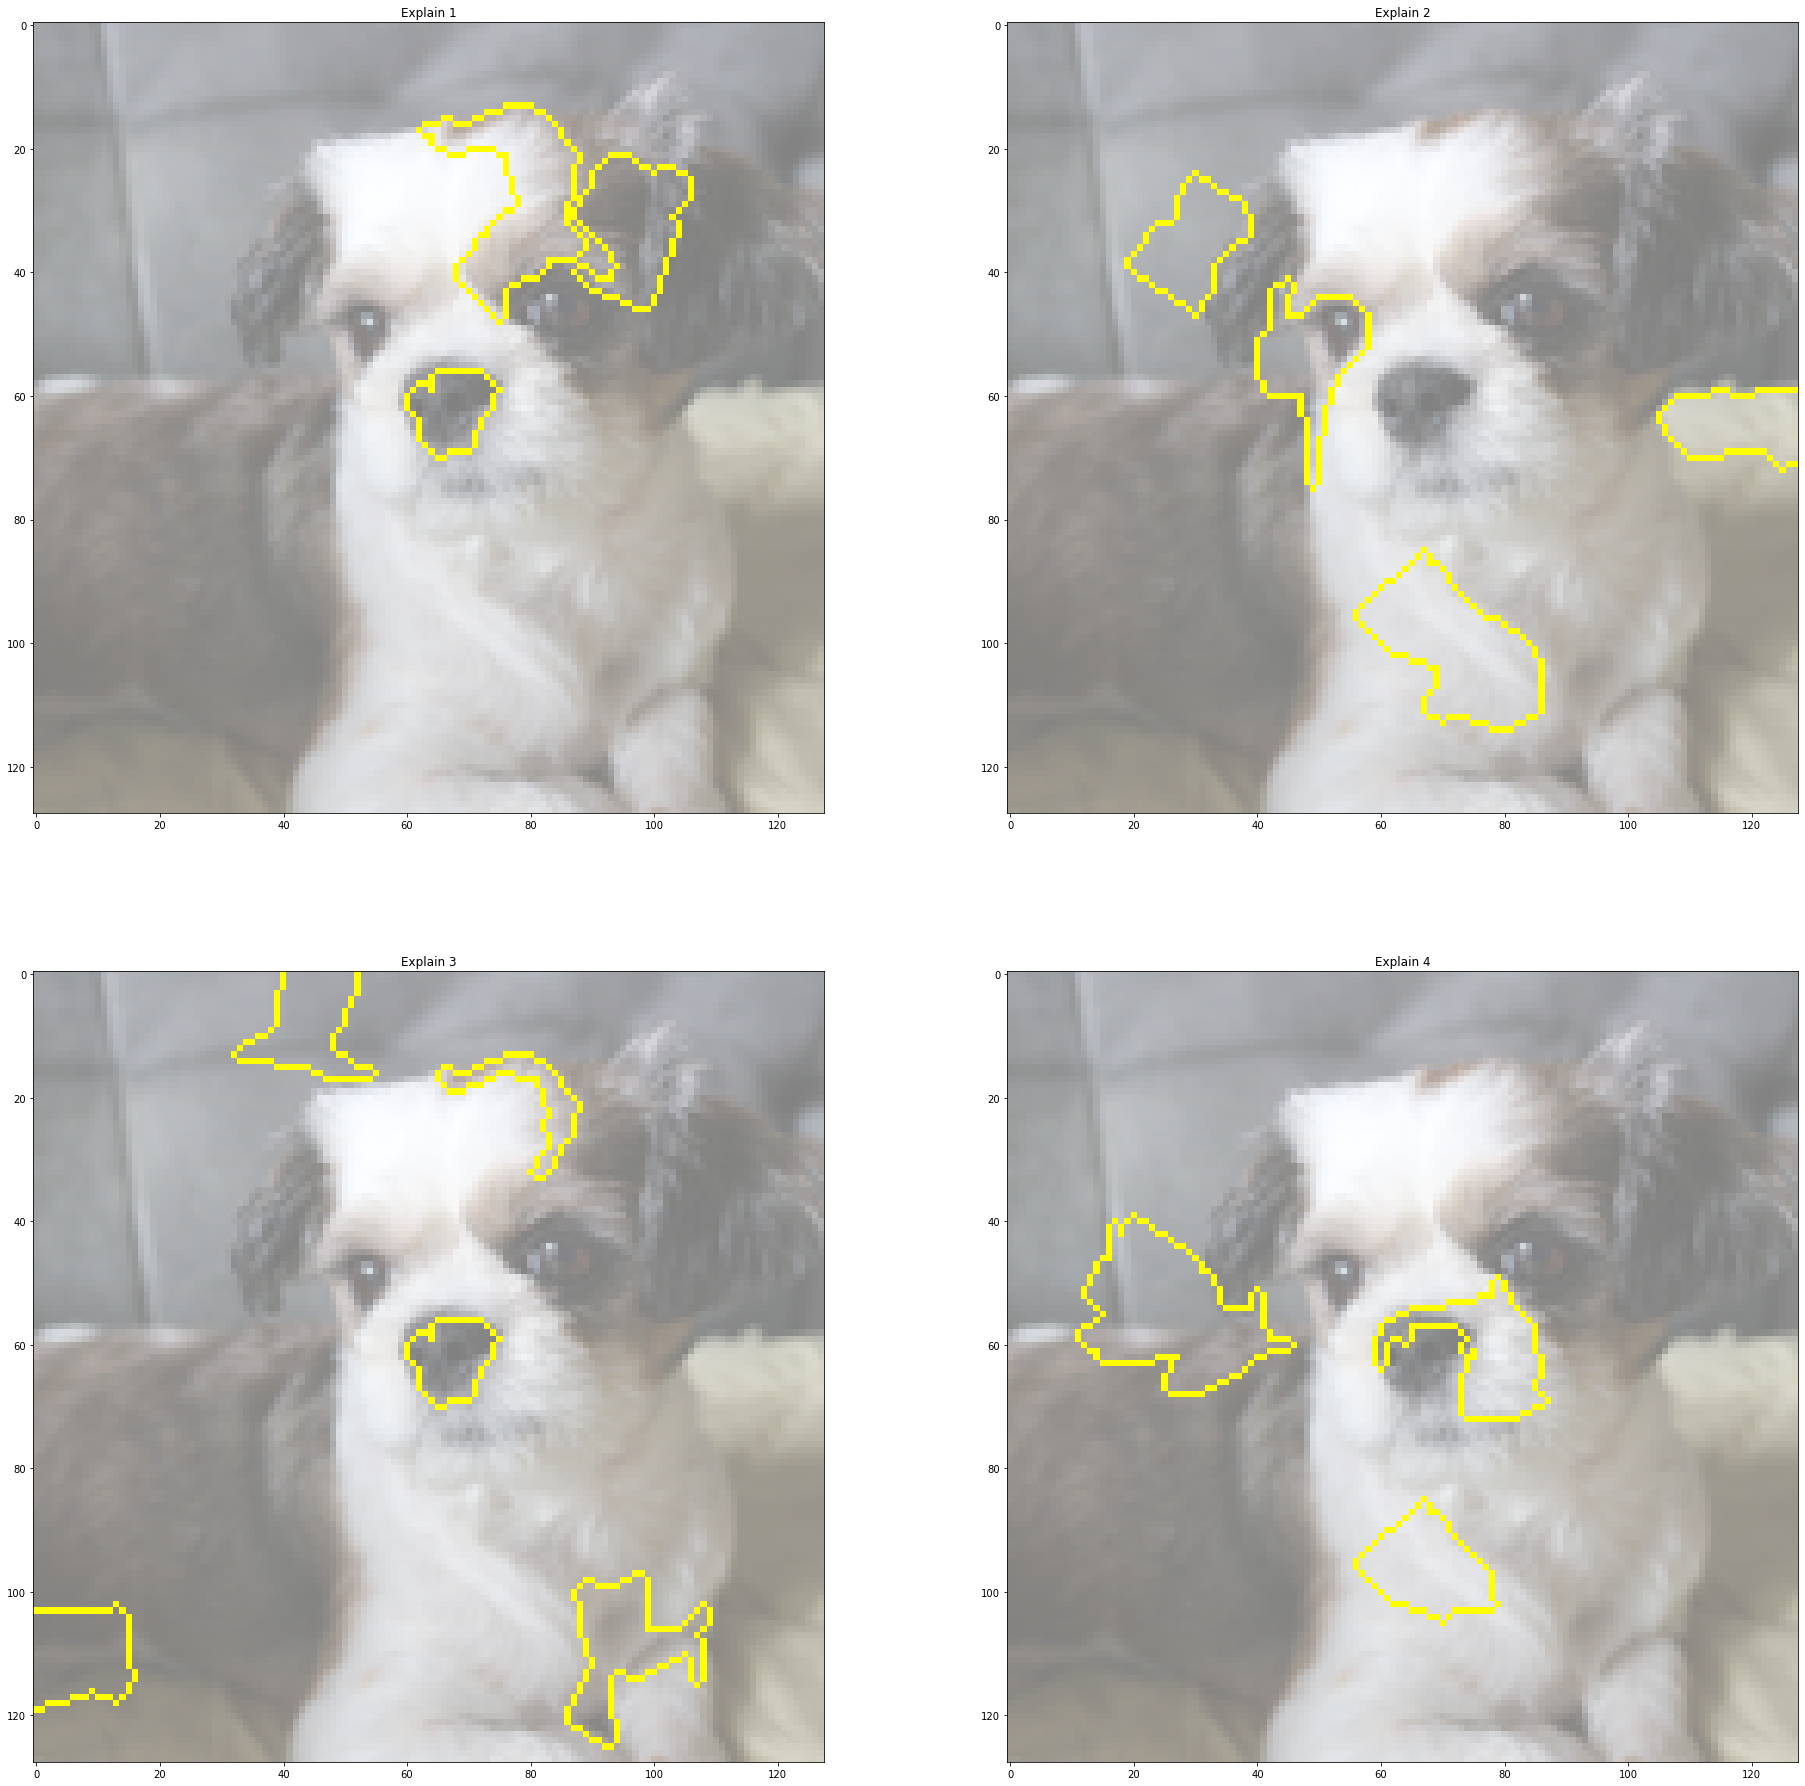

This image is 100.00% shih_tzu


In [170]:
img_path = '../jjang.jpeg'
explain_image(img_path)

100%|██████████| 1000/1000 [00:08<00:00, 118.95it/s]


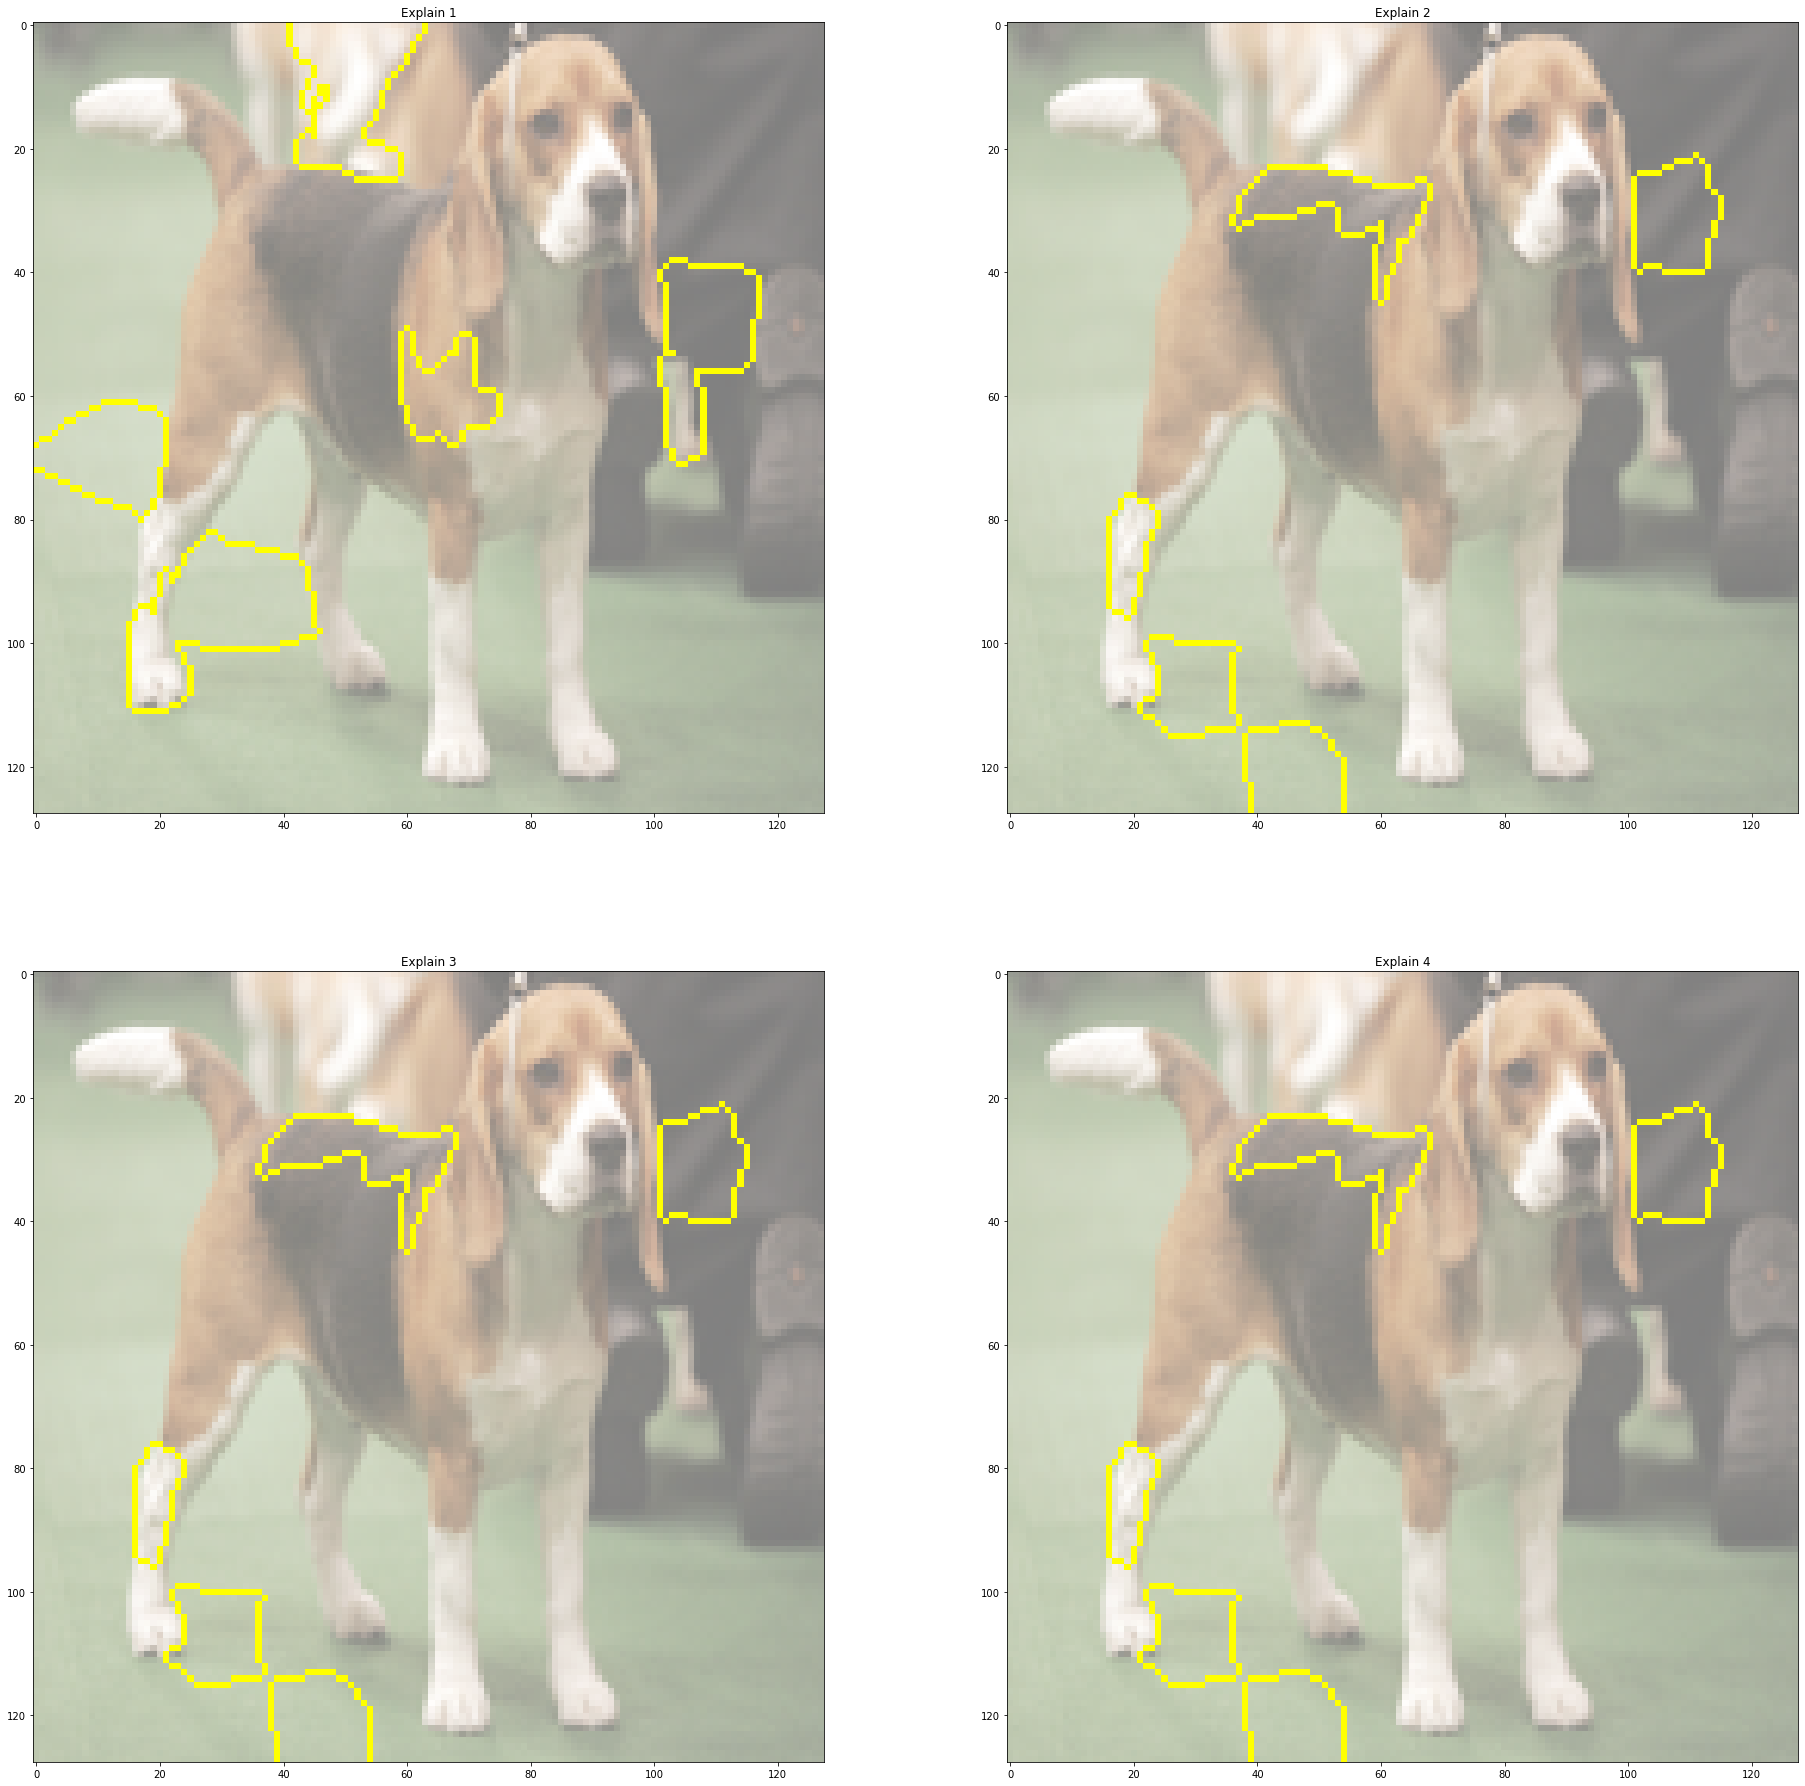

This image is 100.00% beagle


In [172]:
img_path = '../beagle.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:08<00:00, 121.76it/s]


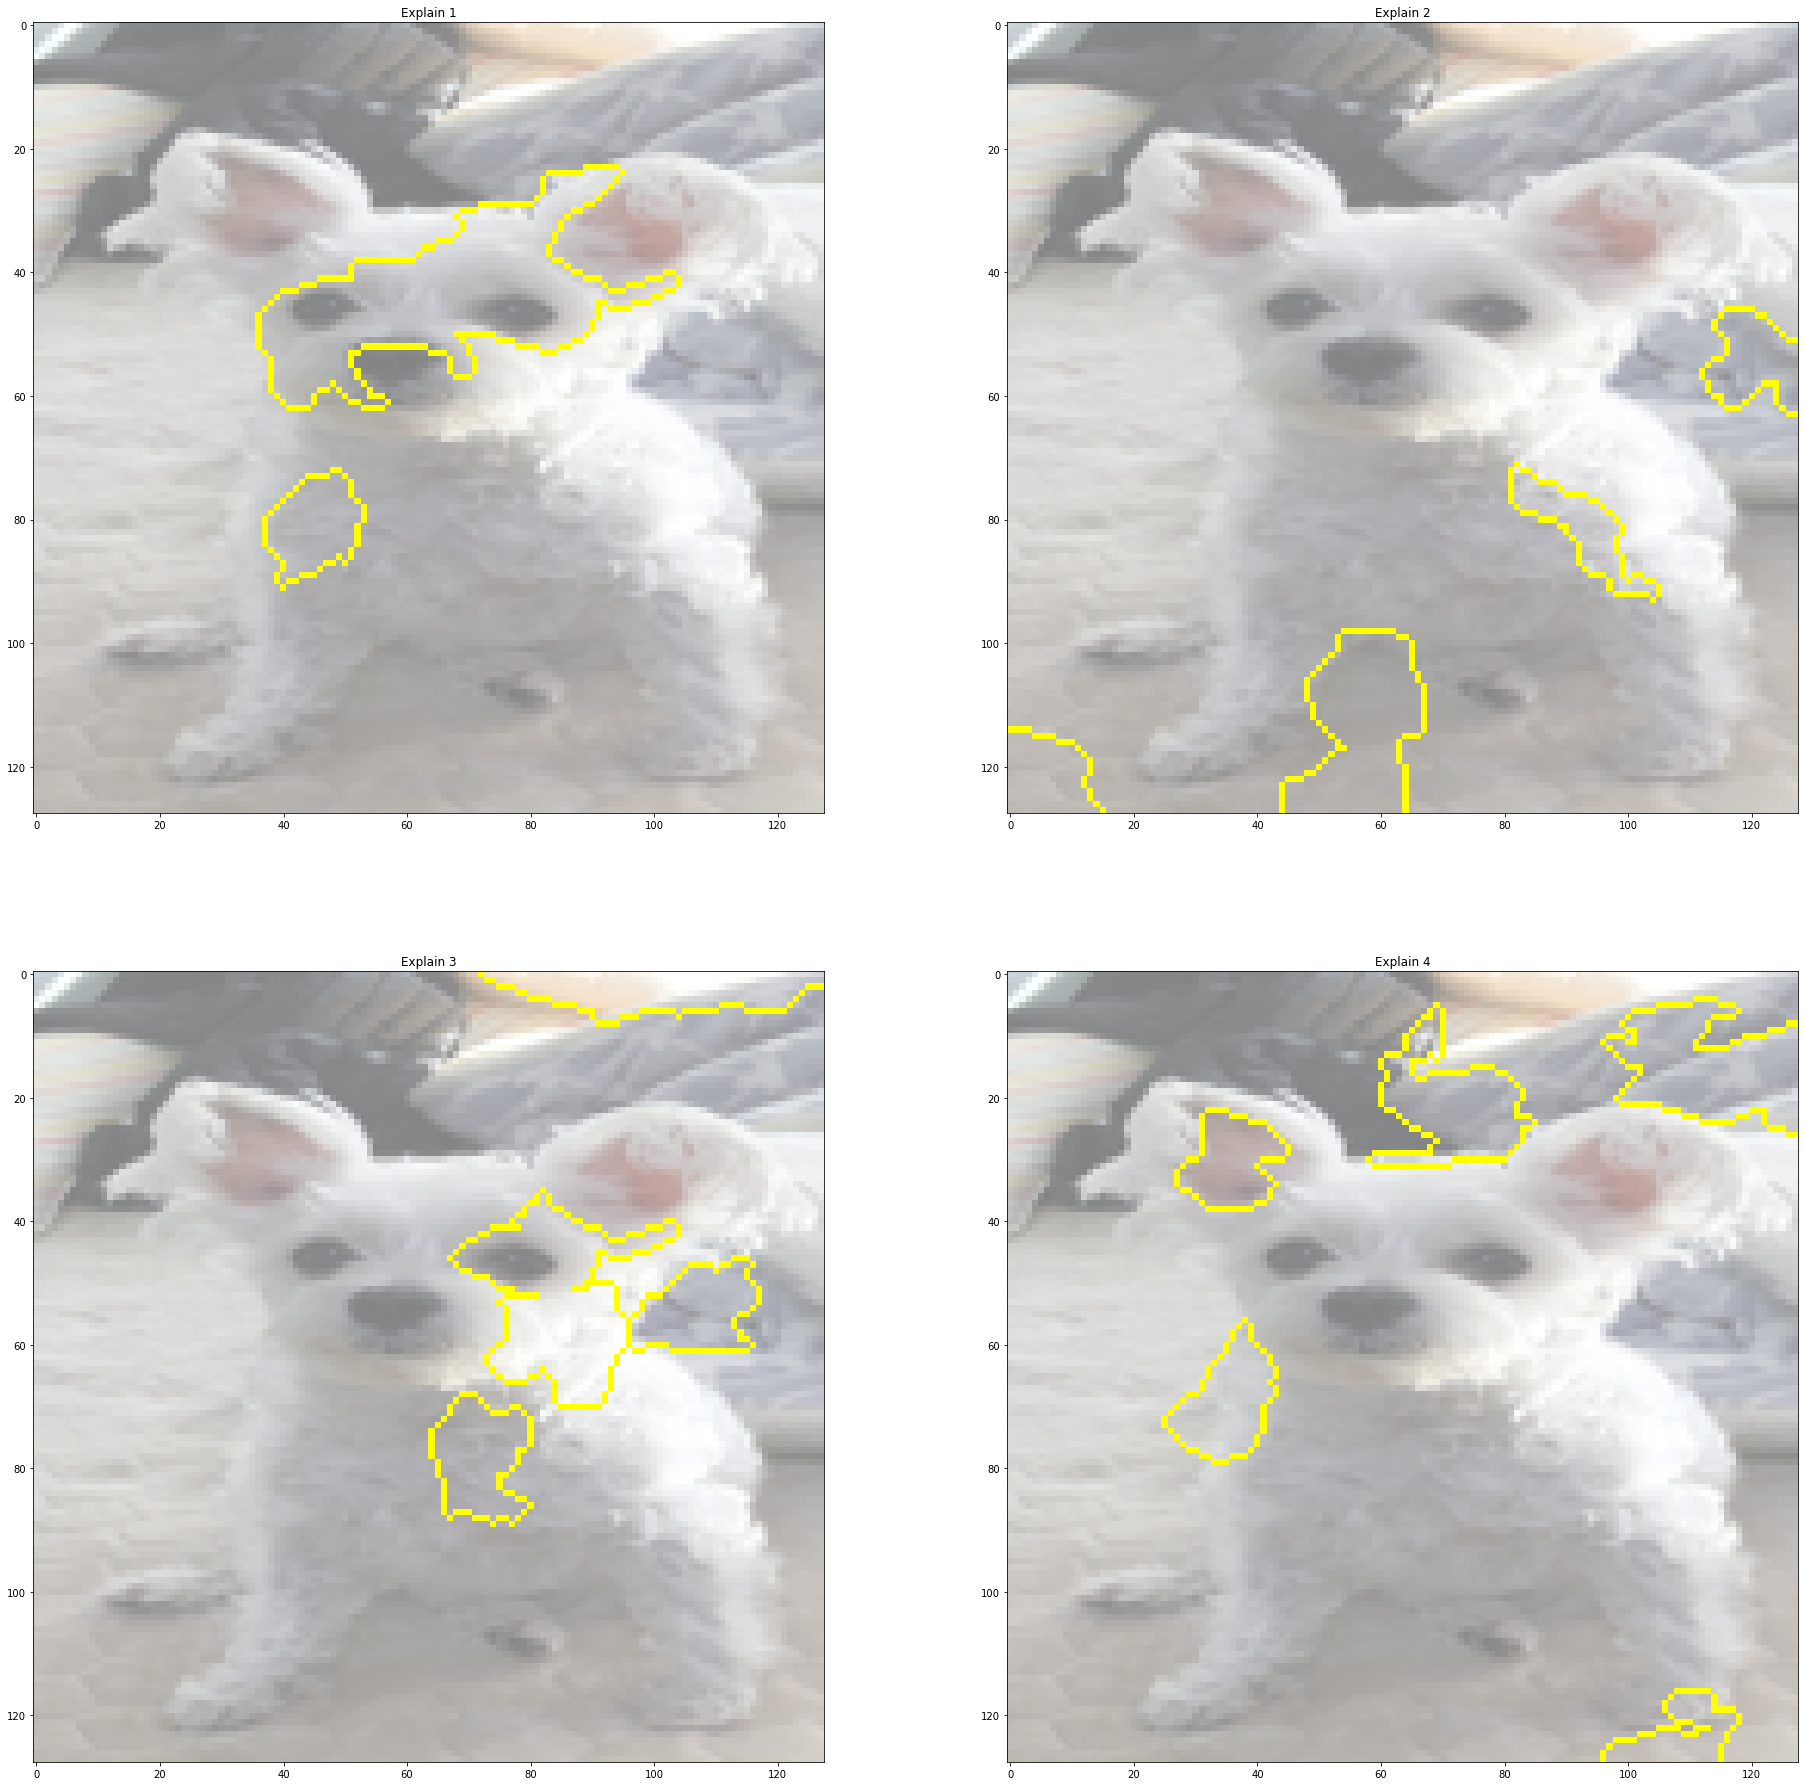

This image is 93.16% maltese


In [173]:
img_path = '../mint3.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:08<00:00, 118.92it/s]


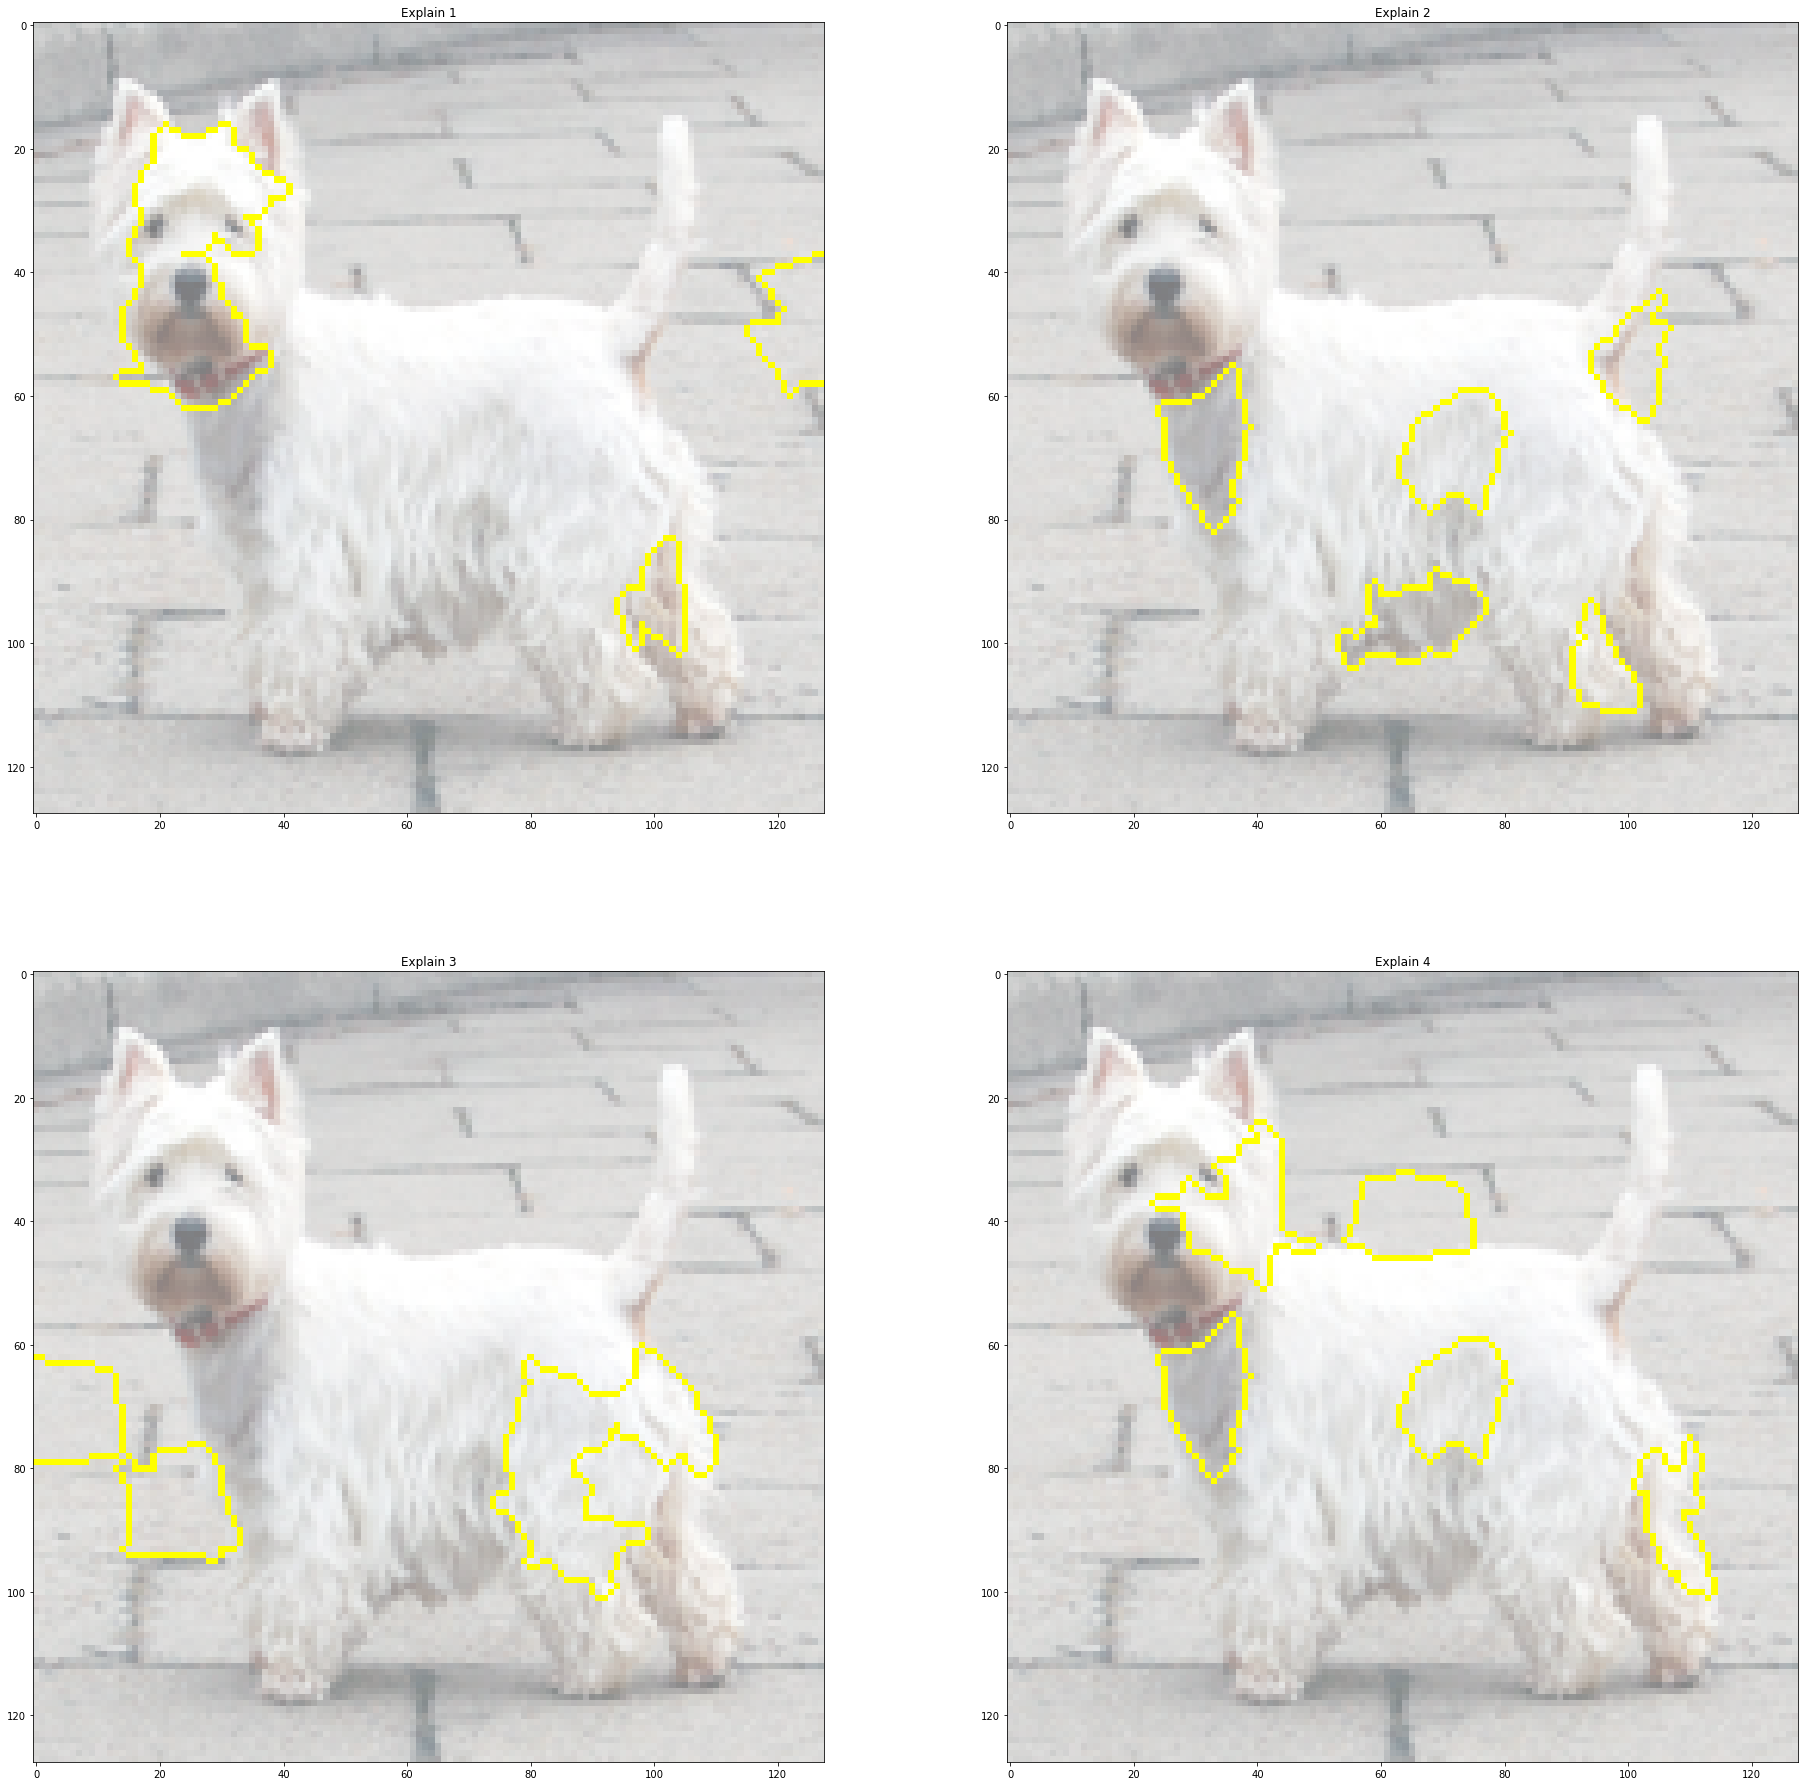

This image is 99.98% white_terrier


In [174]:
img_path = '../asd.jpeg'
explain_image(img_path)
